In [1]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import subprocess
from dtw import correlate
import json
import librosa
import IPython.display as ipd
from random import random
import math

MAX_AUDIO_DURATION = 0.5
MAX_SAMPLE_COUNT_PER_ARTIST = 100
MAX_SAMPLE_COMPARISON_COUNT = 500

apppath = os.path.expanduser('/Users/andrusasumets/projects/experiments/pacemaker/')
processedpath = os.path.join(apppath, 'processed/')
soxipath = os.path.join(processedpath, 'soxi/')
wavpath = os.path.join(processedpath, 'wav/')
audiopath = os.path.join(processedpath, 'audio/')
dtwpath = os.path.join(processedpath, 'dtw/')
extensionpath = os.path.join(apppath, 'pacemaker WatchKit Extension/data/')
extensionsamplepath = os.path.join(extensionpath, 'samples/')
librarypath = os.path.expanduser('/Volumes/LaCie/freesound-crawler/downloads/')
allowedfileformats = ['wav', 'aiff', 'flac', 'ogg', 'mp3', 'm4a']
audiofileformat = 'm4a'

In [2]:
f = open(apppath + 'artists.txt')
artists = ''.join(f.readlines()).strip().replace('\n', ',').split(',')
print('artists:', len(artists))
print(artists)

artists: 53
['gameaudio', 'egolessdub', 'batchku', 'dneproman', 'walter-odington', 'errorcell', 'drfx', 'adcbicycle', 'potentjello', 'phr4kture', 'rutgermuller', 'sturmankin', 'ianstargem', 'pjcohen', 'the-very-real-horst', 'felix-blume', 'firnwald', 'suicidity', 'veiler', 'ecodtr', 'martian', 'kanito', 'soneproject', 'cormi', 'john-scott', 'kyles', 'rucisko', 'spankmyfilth', 'samplecat', 'schafferdavid', 'galeku', 'jjbbllkk', 'hello-flowers', 'psysofastia', 'growingup', 'adcbicycle', 'ianstargem', 'ecodtr', 'owlstorm', 'nox-sound', 'chaad', 'giomilko', 'carlmartin', 'art6nik', 'unfav', 'deadrobotmusic', 'kreutzkamp', 'staticpony1', 'the-sacha', 'vinjatovix', 'owstu', 'phantastonia', 'cpolcyn']


In [3]:
def get_fileformat(filename):
    return filename.split('.')[len(filename.split('.')) - 1]

all_filenames = [f for f in os.listdir(librarypath)]
fileformats = {}
for filename in all_filenames:
    fileformat = get_fileformat(filename)
    
    if fileformat not in fileformats:
        fileformats[fileformat] = 0
         
    fileformats[fileformat] = fileformats[fileformat] + 1
    
print('fileformats', fileformats)
print('all_filenames:', len(all_filenames))

filenames = [f for f in os.listdir(librarypath) if f.endswith(tuple(allowedfileformats))]
filenames = [f for f in filenames if f.count('__') == 2]
processedfilenames = [f for f in os.listdir(audiopath) if f.endswith(audiofileformat)]

fileformats {'wav': 25016, 'aiff': 12304, 'flac': 1697, 'ogg': 323, 'mp3': 1001, 'crdownload': 6, 'DS_Store': 1, 'm4a': 14}
all_filenames: 40362


In [4]:
def create_or_read_file(command, outfilename):
    if os.path.exists(outfilename):
        f = open(outfilename, "r")
        out = ''.join(f.readlines())
        f.close()
        return out
    else:
        try:
            out = str(subprocess.check_output(command).decode(encoding="utf-8")).strip().replace('\\n', '').replace("'", "")

            with open(outfilename, 'w') as file:
                file.write(out)

            return out
        except Exception as e:
            return 

In [5]:
def process(command):
    subprocess.check_output(command)

sample_artists = {}
sample_durations = {}
res = []

for filename in filenames:
    fileartist = filename.split("__")[1].split("__")[0]
    fileid = filename.split('__')[0]
    audiofilename = fileid + '.' + audiofileformat

    #if fileartist not in artists:
        #continue
        
    if fileartist not in sample_artists:
        sample_artists[fileartist] = 0
        
    sample_artists[fileartist] = sample_artists[fileartist] + 1
    
    if sample_artists[fileartist] >= MAX_SAMPLE_COUNT_PER_ARTIST:
        continue
    
    soxi_out = create_or_read_file(['soxi', '-D', librarypath + filename], soxipath + fileid + '.soxi')
    if not soxi_out:
        continue
    
    sample_duration = float(soxi_out)
    if sample_duration > MAX_AUDIO_DURATION:
        continue
        
    if audiofilename not in processedfilenames:
        process(['ffmpeg', '-loglevel', 'error', '-i', librarypath + filename, '-acodec', 'pcm_s16le', '-ac', '1', '-ar', '100', '-threads', '6', '-y', wavpath + fileid + '.wav'])
        process(['ffmpeg', '-loglevel', 'error', '-i', librarypath + filename, '-ar', '44100', '-threads', '6', '-y', audiopath + audiofilename])
        
    sample_durations[fileid] = sample_duration
    res.append(audiofilename)

filenames = res
print(filenames)
print(len(filenames))
print(sample_artists)

soxi FAIL formats: can't open input file `/Volumes/LaCie/freesound-crawler/downloads/164620__deleted-user-2104797__car-interior-driving-2.wav': WAVE file fmt with padded samples is not supported yet
soxi FAIL formats: can't open input file `/Volumes/LaCie/freesound-crawler/downloads/324532__deleted-user-2104797__pop-balloon-1.wav': WAVE file fmt with padded samples is not supported yet
soxi FAIL formats: can't open input file `/Volumes/LaCie/freesound-crawler/downloads/324512__deleted-user-2104797__hedge-clippers.wav': WAVE file fmt with padded samples is not supported yet
soxi FAIL formats: can't open input file `/Volumes/LaCie/freesound-crawler/downloads/324536__deleted-user-2104797__pop-balloon-4.wav': WAVE file fmt with padded samples is not supported yet
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: can't open input file `/Volumes/LaCie/freesound-crawler/downloads/583309__proxmo-kashacir__aaaaaaaah.aiff': AIFF header does not begin with magic word `FORM

['626685.m4a', '267818.m4a', '194063.m4a', '335813.m4a', '194138.m4a', '349729.m4a', '8735.m4a', '456471.m4a', '375658.m4a', '582707.m4a', '375817.m4a', '10090.m4a', '621916.m4a', '139601.m4a', '375833.m4a', '384147.m4a', '139582.m4a', '250445.m4a', '488202.m4a', '375879.m4a', '335842.m4a', '375881.m4a', '54011.m4a', '582664.m4a', '577162.m4a', '53628.m4a', '542848.m4a', '459223.m4a', '183332.m4a', '183358.m4a', '107283.m4a', '375639.m4a', '508574.m4a', '335828.m4a', '107868.m4a', '457699.m4a', '467784.m4a', '188383.m4a', '37404.m4a', '183367.m4a', '459232.m4a', '584786.m4a', '260336.m4a', '621717.m4a', '349721.m4a', '626708.m4a', '158935.m4a', '349725.m4a', '101065.m4a', '350382.m4a', '335832.m4a', '178757.m4a', '626692.m4a', '194090.m4a', '506765.m4a', '404743.m4a', '335812.m4a', '250458.m4a', '191252.m4a', '349735.m4a', '10019.m4a', '258872.m4a', '90809.m4a', '194054.m4a', '375674.m4a', '626623.m4a', '49062.m4a', '245733.m4a', '159680.m4a', '421387.m4a', '584800.m4a', '577176.m4a', 

soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'


In [6]:
def create_or_read_file(filename, command):
    if os.path.exists(filename):
        f = open(filename, "r")
        out = ''.join(f.readlines())
        f.close()
        return out
    else:
        try:
            out = str(subprocess.check_output(command).decode(encoding="utf-8")).strip().replace('\\n', '').replace("'", "")

            with open(filename, 'w') as file:
                file.write(out)

            return out
        except Exception as e:
            return 

In [7]:
df = pd.DataFrame()
out_distances = {}
full_distances = []

for leftfilename in filenames:
    leftid = leftfilename.split('.')[0]
    rightfilenames = filenames
    rightfilenames = sorted(rightfilenames, key=lambda x: random())
    
    for righti, rightfilename in enumerate(rightfilenames):
        if (len(full_distances) % 100) == 0 and righti == 0:
            print(str(len(full_distances)) + " / " + str(len(filenames) * MAX_SAMPLE_COMPARISON_COUNT))
            
        if righti >= MAX_SAMPLE_COMPARISON_COUNT:
            continue
        
        if leftfilename == rightfilename:
            continue
            
        rightid = rightfilename.split('.')[0]
            
        try:
            correlation = correlate(wavpath, leftid, rightid, 'wav', dtwpath)
            
            if math.isinf(float(correlation)):
                continue
                
            if math.isnan(float(correlation)):
                continue
            
            df.loc[leftid, rightid] = correlation
            df.loc[rightid, leftid] = correlation

            if leftid not in out_distances:
                out_distances[leftid] = []
            
            sample_duration = sample_durations[leftid]
            out_distances[leftid].append([correlation, sample_duration, int(rightid)])
            full_distances.append([correlation, leftid, rightid])

        except Exception as e:
            pass

for filename in out_distances:
    out_distances[filename] = sorted(out_distances[filename])
    
if not os.path.exists(extensionpath):
    os.makedirs(extensionpath)
            
with open(extensionpath + 'distances.json', 'w') as fp:
    json.dump(out_distances, fp)
    
full_distances = sorted(full_distances)
print(len(full_distances))

0 / 1126500


/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/U

93300 / 1126500
127900 / 1126500
127900 / 1126500
163600 / 1126500
184400 / 1126500
189300 / 1126500
273500 / 1126500
290200 / 1126500
344500 / 1126500
418000 / 1126500
438000 / 1126500
470435


In [8]:
delimiter = '|'
samples = {}
filtered_filenames = [f for f in os.listdir(dtwpath) if f.endswith('.dtw')]

for filename in filtered_filenames:
    filename = filename.split('.dtw')[0]
    left, right = filename.split(delimiter)
    
    if left not in samples:
        samples[left] = []
        
    if right not in samples:
        samples[right] = []
        
    samples[left].append(right)
    samples[right].append(left)

In [9]:
if not os.path.exists(extensionsamplepath):
    os.makedirs(extensionsamplepath)

saved = []

for distance in full_distances:
    leftid = distance[1]
    
    if leftid in saved:
        continue
        
    saved.append(leftid)
    
    source = audiopath + leftid + '.' + audiofileformat
    target = extensionsamplepath + leftid + '.' + audiofileformat
    command = ['cp', source, target]
    process(command)

print(len(saved))

1457


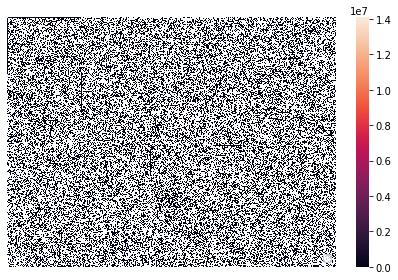

In [13]:
plot = sns.heatmap(df, xticklabels=False, yticklabels=False)
handles, labels = plot.get_legend_handles_labels()
plot.legend(reversed(handles), reversed(labels), title='', loc="lower right")
fig = plot.get_figure()
fig.tight_layout()
fig.savefig(extensionpath + "heatmap.png", dpi=1000, facecolor="white")

In [11]:
def show_audio(comparison):
    distance, leftid, rightid = comparison
    print(distance)

    data, rate = librosa.core.load(audiopath + leftid + '.' + audiofileformat)
    ipd.display(ipd.Audio(data, rate=rate))

    data, rate = librosa.core.load(audiopath + rightid + '.' + audiofileformat)
    ipd.display(ipd.Audio(data, rate=rate))

display_count = 10
for i in range(display_count):
    if (i % 2) == 0:
        show_audio(full_distances[i])
        
for i in range(display_count):
    if (i % 2) == 0:
        show_audio(full_distances[i - display_count])

0.0


/usr/local/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


/usr/local/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


0.0005302592738342798


0.0006250000000000011


0.0016296296296296297


0.002289156182652103


7156639.5625


7159458.042366692


7186485.809999998


7480804.527777778


10476830.631492436
